# Heritage Annual Report NLP Pipeline (2024–25)

A clean, modular NLP workflow tailored to the Heritage annual report. The notebook:
- Loads the PDF and stores each page in a DataFrame
- Applies robust preprocessing (normalization, cleaning, stopwords, lemmatization)
- Computes sentence-level sentiment using TextBlob
- Tokenizes words, explores frequent terms, and builds a wordcloud
- Creates TF‑IDF and a document-term matrix
- Trains a 10-topic LDA model (Gensim)
- Exports artifacts for a separate Streamlit FAQ chatbot (`faq_app.py`)



In [ ]:
# --- Environment and Imports ---
import sys
import subprocess

# Ensure required packages are available (idempotent installs)
for pkg in [
    "numpy", "pandas", "nltk", "textblob", "wordcloud", "PyMuPDF",
    "scikit-learn", "gensim", "matplotlib"
]:
    try:
        __import__(pkg.replace('-', '_'))
    except Exception:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", pkg])

import re
import json
import numpy as np
import pandas as pd
import fitz  # PyMuPDF
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from textblob import TextBlob

from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

import gensim
from gensim import corpora

# Download NLTK resources (safe if already present)
for resource in ["punkt", "stopwords", "wordnet"]:
    try:
        nltk.data.find(f"tokenizers/{resource}")
    except LookupError:
        nltk.download(resource)

print("Environment ready.")


Environment ready.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rudra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rudra\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# --- Load PDF into DataFrame ---
from pathlib import Path

pdf_path = Path(r"C:\Users\rudra\Desktop\nlpp\proj\Heritage_Annual_Report_2024-25.pdf")
assert pdf_path.exists(), f"PDF not found at: {pdf_path}"

with fitz.open(str(pdf_path)) as doc:
    pages = [
        {"page_number": i + 1, "text": doc.load_page(i).get_text()}
        for i in range(len(doc))
    ]

df_pages = pd.DataFrame(pages)
print("Pages loaded:", len(df_pages))
df_pages.head()


Pages loaded: 254


,page_number,text
0,1,Heritage Foods Limited \n33rd Annual Report\n2...
1,2,In a world where tastes shift with every sunri...
2,3,"DELIGHTING CONSUMERS, \nNURTURING GROWTH… \n…I..."
3,4,"FINANCIAL \nHIGHLIGHTS, FY25\nD40,805 MN\nREVE..."
4,5,"CHAIRPERSON'S \nMESSAGE\nDear Stakeholders,\nI..."


In [ ]:
# --- Text Preprocessing Utilities ---
STOP_WORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

_clean_re_list = [
    (re.compile(r"\s+"), " "),               # collapse whitespace
    (re.compile(r"\d+"), " "),               # remove digits
    (re.compile(r"[^a-zA-Z\s]"), " "),      # remove punctuation/specials
]

def normalize(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = text.lower().strip()
    for pattern, repl in _clean_re_list:
        text = pattern.sub(repl, text)
    return re.sub(r"\s+", " ", text).strip()


def remove_stopwords(tokens):
    return [t for t in tokens if t not in STOP_WORDS and len(t) > 2]


def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(t) for t in tokens]


def preprocess_document(text: str) -> str:
    base = normalize(text)
    tokens = word_tokenize(base)
    tokens = remove_stopwords(tokens)
    tokens = lemmatize_tokens(tokens)
    return " ".join(tokens)

# Apply to each page
df_pages['processed_text'] = df_pages['text'].apply(preprocess_document)
print("Preprocessing complete.")
df_pages[['page_number','processed_text']].head()


Preprocessing complete.


,page_number,processed_text
0,1,heritage food limited annual report delighting...
1,2,world taste shift every sunrise expectation cl...
2,3,delighting consumer nurturing growth slogan me...
3,4,financial highlight revenue operation ebitda g...
4,5,chairperson message dear stakeholder privilege...


In [ ]:
# --- Sentence Tokenization & Sentiment ---
sentiment_rows = []
for _, row in df_pages.iterrows():
    sentences = sent_tokenize(row['text'] or "")
    for sent in sentences:
        blob = TextBlob(sent)
        sentiment_rows.append({
            "page_number": row['page_number'],
            "sentence": sent.strip(),
            "polarity": float(blob.sentiment.polarity),
            "subjectivity": float(blob.sentiment.subjectivity),
        })

sentiment_df = pd.DataFrame(sentiment_rows)

print("Sentences:", len(sentiment_df))
sentiment_df.head(10)


Sentences: 4967


,page_number,sentence,polarity,subjectivity
0,1,Heritage Foods Limited \n33rd Annual Report\n2...,-0.071429,0.142857
1,2,In a world where tastes shift with every sunri...,0.000000,0.000000
2,2,"AT HERITAGE FOODS, WE CHOOSE \nMOMENTUM OVER M...",0.000000,0.000000
3,2,CONTENT\n02-21\n22-41\n42-270\n33 YRS \nRICH L...,0.056481,0.240741
4,2,"AT HERITAGE FOODS, WE CHOOSE \nMOMENTUM OVER M...",0.000000,0.000000
5,2,CONTENT\n02-21\n22-41\n42-270\n33 YRS \nRICH L...,0.056481,0.240741
6,3,"DELIGHTING CONSUMERS, \nNURTURING GROWTH… \n…I...",0.136364,0.500000
7,3,FROM \nEXCITING NEW FLAVOURS AND DIGITAL TOUCH...,0.145455,0.418182
8,3,"To us, growth is more than numbers—it is inclu...",0.500000,0.500000
9,3,"We \nmeasure it in better livelihoods, smarter...",0.500000,0.500000


Top 25 tokens:
[('company', 1942), ('financial', 1065), ('year', 950), ('march', 747), ('director', 668), ('report', 551), ('board', 536), ('asset', 529), ('statement', 500), ('share', 481), ('value', 432), ('amount', 429), ('heritage', 418), ('policy', 415), ('limited', 400), ('act', 399), ('management', 378), ('food', 344), ('india', 329), ('tax', 317), ('risk', 317), ('audit', 312), ('term', 310), ('regulation', 304), ('total', 302)]


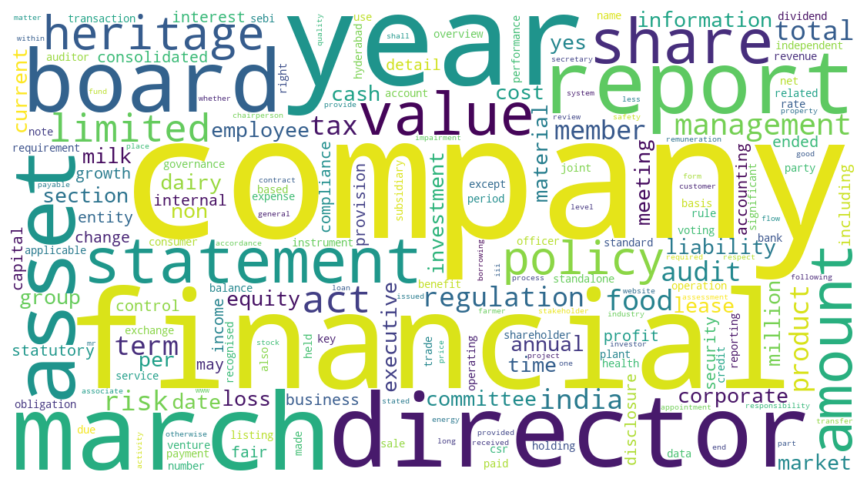

In [ ]:
# --- Word Frequencies & Wordcloud ---
from nltk.probability import FreqDist

all_tokens = " ".join(df_pages['processed_text'].tolist())
all_tokens = word_tokenize(all_tokens)
fdist = FreqDist(all_tokens)

print("Top 25 tokens:")
print(fdist.most_common(25))

wc = WordCloud(
    width=1100,
    height=600,
    background_color="white",
    colormap="viridis",
).generate_from_frequencies(fdist)

plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()


In [ ]:
# --- TF-IDF and Document-Term Matrix ---
corpus_documents = df_pages['processed_text'].tolist()

vectorizer = TfidfVectorizer(max_features=1500, min_df=2)
tfidf_matrix = vectorizer.fit_transform(corpus_documents)

print("TF-IDF shape:", tfidf_matrix.shape)

# Persist artifacts for chatbot usage
chatbot_payload = {
    "pages": df_pages[['page_number', 'text']].to_dict(orient='records'),
    "vocabulary": vectorizer.vocabulary_,
    "tfidf_matrix": tfidf_matrix.toarray().tolist(),
}

# Ensure all numpy/scikit types are JSON serializable

def convert_types(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    if isinstance(obj, np.floating):
        return float(obj)
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if isinstance(obj, dict):
        return {k: convert_types(v) for k, v in obj.items()}
    if isinstance(obj, list):
        return [convert_types(i) for i in obj]
    return obj

serializable_payload = convert_types(chatbot_payload)

with open('chatbot_data.json', 'w', encoding='utf-8') as f:
    json.dump(serializable_payload, f, ensure_ascii=False, indent=2)

print("Saved chatbot_data.json")


TF-IDF shape: (254, 1500)
Saved chatbot_data.json


In [ ]:
# --- LDA Topic Modeling (10 topics) ---
# Prepare tokens list for Gensim
page_tokens = [word_tokenize(txt) for txt in df_pages['processed_text']]

# Build dictionary and corpus
dictionary = corpora.Dictionary(page_tokens)
corpus = [dictionary.doc2bow(tokens) for tokens in page_tokens]

lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=10,
    random_state=123,
    update_every=1,
    chunksize=150,
    passes=8,
    alpha='auto',
    per_word_topics=True,
)

for idx, topic in lda_model.print_topics(num_topics=10, num_words=12):
    print(f"Topic {idx}: {topic}")


Topic 0: 
 0.050*"director" + 0.026*"company" + 0.024*"executive" + 0.024*"board" + 0.021*"committee" + 0.013*"independent" + 0.013*"officer" + 0.012*"non"
Topic 1: 
 0.032*"financial" + 0.020*"risk" + 0.018*"statement" + 0.017*"company" + 0.012*"equity" + 0.012*"audit" + 0.012*"march" + 0.011*"value"
Topic 2: 
 0.041*"company" + 0.032*"policy" + 0.019*"yes" + 0.010*"management" + 0.009*"financial" + 0.008*"corporate" + 0.008*"business" + 0.007*"code"
Topic 3: 
 0.023*"voting" + 0.020*"nsdl" + 0.014*"shareholder" + 0.011*"password" + 0.011*"login" + 0.010*"user" + 0.009*"demat" + 0.009*"share"
Topic 4: 
 0.059*"company" + 0.021*"regulation" + 0.018*"act" + 0.018*"audit" + 0.018*"report" + 0.016*"board" + 0.013*"section" + 0.012*"india"
Topic 5: 
 0.033*"member" + 0.027*"share" + 0.024*"company" + 0.017*"dividend" + 0.014*"number" + 0.013*"voting" + 0.010*"agm" + 0.010*"bank"
Topic 6: 
 0.023*"march" + 0.020*"asset" + 0.019*"year" + 0.017*"financial" + 0.014*"company" + 0.014*"amount" +